In [15]:
import os
import torch
import torch.optim as optim
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import random

from data_loader import NuplanDataLoader, create_data_loaders
from model import RoadMind
from train import train_model
from utils import load_checkpoint, plot_results

In [ ]:
# Parameters
data_dir = '../data'
batch_size = 32
num_workers = 4
learning_rate = 0.001
epochs = 50
download_data = False  # Set to False if data is already downloaded

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create data directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Initialize data loader and download/extract dataset if needed
loader = NuplanDataLoader(data_dir=data_dir, download=download_data)

# Create data loaders for training, validation and testing
train_loader, val_loader, test_loader = create_data_loaders(loader, batch_size=batch_size, num_workers=num_workers)

# Initialize the model
model = RoadMind()

# print(summary(model, [(1, 3, 200, 300), (1, 1,), (1, 21, 3)],
#         dtypes=[torch.float32, torch.long, torch.float32],
#         device="cpu"))

model = model.to(device)

# Initialize optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate,  weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.2, patience=5)

saved_epoch, _ = load_checkpoint(model, optimizer, checkpoint_path = "../outputs/checkpoints/checkpoint.pth")
if saved_epoch == 0:
    start_epoch = 0
else:
    start_epoch = saved_epoch + 1  #if the checkpoint from the epoch saved_epoch is stored, we want to start the training from the next epoch

# Create a model directory
model_path = '../model'
os.makedirs(model_path, exist_ok=True)

# Train the model
print(f"Starting training for {epochs} epochs...")
train_losses, val_losses, val_ade, val_fde = train_model(model, train_loader, val_loader, optimizer, scheduler,
                                                         epochs=epochs, start_epoch=start_epoch)

# Save the trained model
torch.save(model.state_dict(), model_path + '/baseline_roadmind_model.pth')
print(f"Model saved to {model_path}/baseline_roadmind_model.pth")

# Plot training and validation losses
plot_results(train_losses, val_losses, val_ade, val_fde)
print("Loss plot saved to ../outputs/training_metrics.png")


Using device: cuda
Initializing data loader...
Creating data loaders...
Train dataset size: 5000
Validation dataset size: 1000
Test dataset size: 1000
Initializing RoadMind model...
Weights initialized...
Layer (type:depth-idx)                   Output Shape              Param #
RoadMind                                 [1, 60, 3]                --
├─Conv2d: 1-1                            [1, 16, 98, 148]          1,216
├─Conv2d: 1-2                            [1, 32, 47, 72]           12,832
├─Conv2d: 1-3                            [1, 64, 22, 34]           51,264
├─AdaptiveAvgPool2d: 1-4                 [1, 64, 5, 5]             --
├─Embedding: 1-5                         [1, 1, 8]                 24
├─LSTM: 1-6                              [1, 21, 32]               4,736
├─Sequential: 1-7                        [1, 180]                  --
│    └─Linear: 2-1                       [1, 256]                  420,096
│    └─ReLU: 2-2                         [1, 256]                  --
│

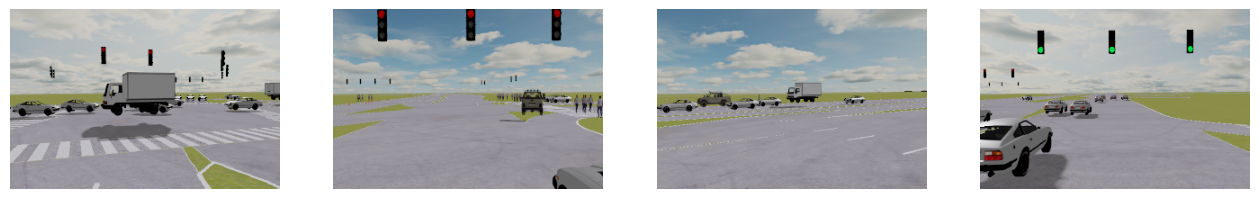

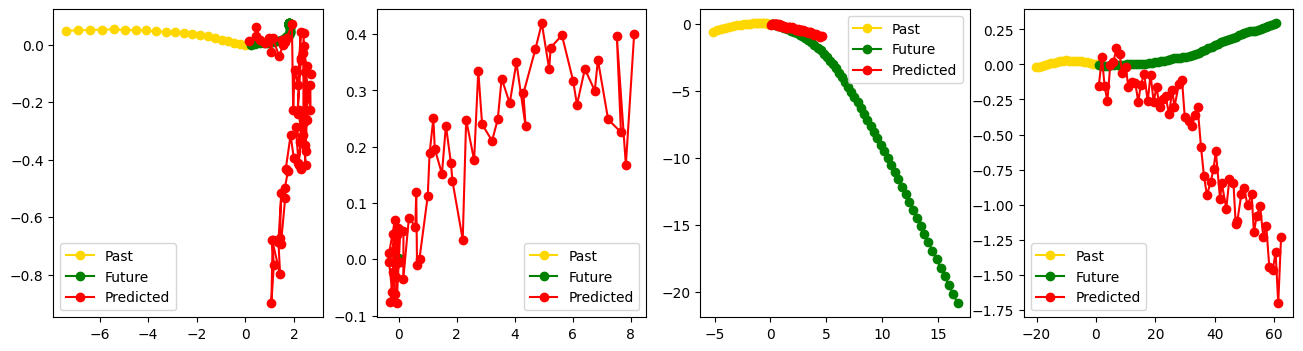

In [17]:
val_batch_zero = next(iter(val_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
camera = val_batch_zero['camera'].to(device)
command = val_batch_zero['driving_command'].to(device)
history = val_batch_zero['sdc_history_feature'].to(device)
future = val_batch_zero['sdc_future_feature'].to(device)

model.eval()
with torch.no_grad():
    pred_future = model(camera, command, history)

camera = camera.cpu().numpy()*255 # unormalize
history = history.cpu().numpy()
future = future.cpu().numpy()
pred_future = pred_future.cpu().numpy()
k=4
selected_indices = random.choices(np.arange(len(camera)), k=k)
# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].imshow(camera[idx].transpose(1, 2, 0)/255)
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].plot(history[idx, :, 0], history[idx, :, 1], "o-", color="gold", label="Past")
    axis[i].plot(future[idx, :, 0], future[idx, :, 1], "o-", color="green", label="Future")
    axis[i].plot(pred_future[idx, :, 0], pred_future[idx, :, 1], "o-", color="red", label="Predicted")
    axis[i].legend()
    axis[i]

In [18]:
import pandas as pd

model.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        driving_command = batch['driving_command'].to(device)
        history = batch['sdc_history_feature'].to(device)
         
        pred_future = model(camera, driving_command, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
submission_dir = '../submission'
os.makedirs(submission_dir, exist_ok=True)
df_xy.to_csv(submission_dir + "/submission_test.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (1000, 121)
